## Chapter 22 - Nominal Predicted Variable

- [22.3.3.1 - Softmax model](#22.3.3.1---Softmax-model)
- [22.3.3.2 - Conditional logistic model](#22.3.3.2---Conditional-logistic-model)

In [8]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from scipy.special import expit
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

### 22.3.3.1 - Softmax model

#### Data

In [9]:
# Using dtype 'category' for Y
df1 = pd.read_csv('data/SoftmaxRegData1.csv', dtype={'Y':'category'})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
X1    475 non-null float64
X2    475 non-null float64
Y     475 non-null category
dtypes: category(1), float64(2)
memory usage: 8.2 KB


In [10]:
df1.head()

,X1,X2,Y
0,-0.087147,-1.081342,2
1,-0.722566,-1.583863,1
2,0.179190,0.971790,3
3,-1.159752,0.502624,3
4,-0.727118,1.375704,3


In [11]:
# Standardize the data
X = df1[['X1', 'X2']]
meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

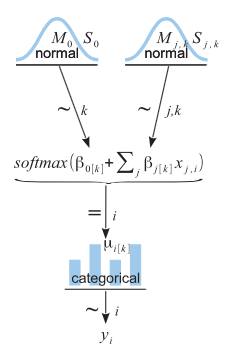

In [12]:
Image('images/fig22_4.png')

In [13]:
# Number of categories
n_cat = df1.Y.cat.categories.size
# Number of dimensions for X
zX_dim =zX.shape[1]

with pm.Model() as model_softmax:
    # priors for categories 2-4, excluding reference category 1 which is set to zero below.
    zbeta0_ = pm.Normal('zbeta0_', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta_ = pm.Normal('zbeta_', mu=0, tau=1/20**2, shape=(zX_dim, n_cat-1))
    
    # add prior values zero (intercept, predictors) for reference category 1.
    zbeta0 = pm.Deterministic('zbeta0', tt.concatenate([[0], zbeta0_]))
    zbeta = pm.Deterministic('zbeta', tt.concatenate([tt.zeros((2, 1)), zbeta_], axis=1))

    mu = zbeta0 + pm.math.dot(zX, zbeta)
    
    # Theano softmax function
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    
    y = pm.Categorical('y', p=p, observed=df1.Y.cat.codes.as_matrix())

In [25]:
with model_softmax:
    trace1 = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 197.98: 100%|██████████| 200000/200000 [00:48<00:00, 4126.31it/s]
Finished [100%]: Average Loss = 197.99
100%|██████████| 50500/50500 [06:55<00:00, 121.43it/s]


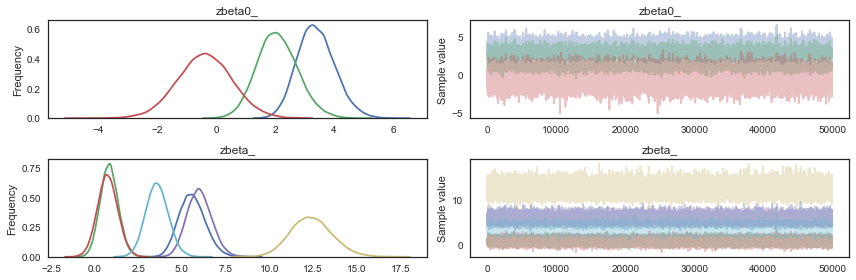

In [26]:
# Traceplot, excluding the parameters for the reference category (which are zero)
pm.traceplot(trace1, ['zbeta0_', 'zbeta_']);

In [27]:
# Transform parameters back to original scale
zbeta0 = trace1['zbeta0']
zbeta = trace1['zbeta']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat,1))/np.tile(scalex, (n_cat,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat,1)).T)

print(beta0.shape)
print(beta.shape)

(50000, 4)
(50000, 2, 4)


In [28]:
# Join the two multi-dimensional arrays
estimates1 = np.insert(beta, 0, beta0, axis=1)
estimates1.shape

(50000, 3, 4)

#### Figure 22.5

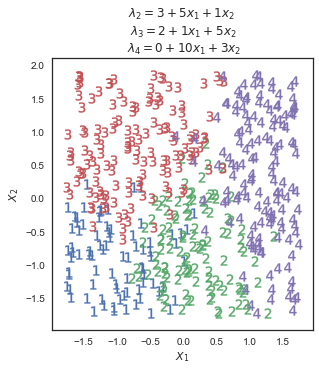

In [29]:
plt.figure(figsize=(5,5))
for outcome in df1.Y.cat.categories:
    plt.scatter(df1[df1.Y == outcome].X1, df1[df1.Y == outcome].X2, s=100, marker='${}$'.format(outcome))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_2 = 3+5x_1+1x_2$ \n $\lambda_3 = 2+1x_1+5x_2$ \n $\lambda_4 = 0+10x_1+3x_2$')
plt.gca().set_aspect('equal')

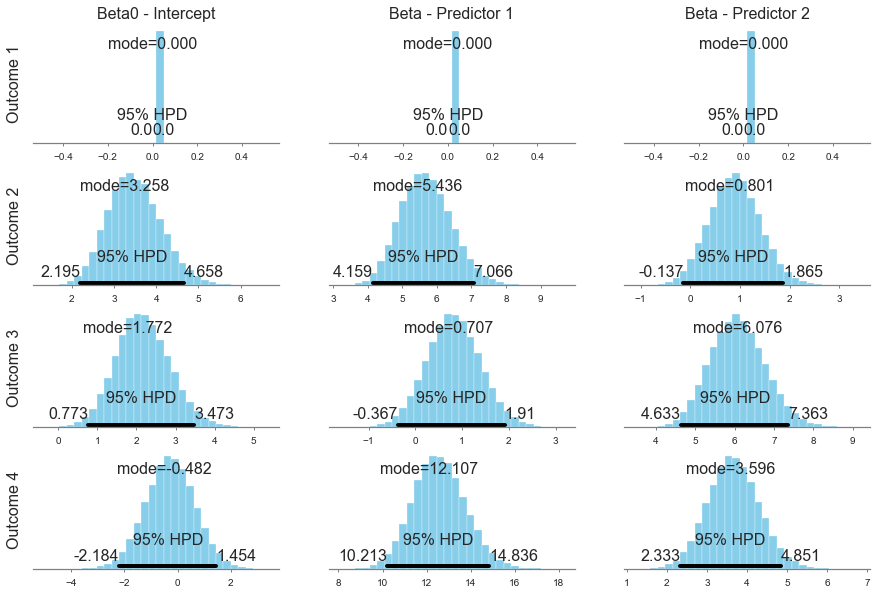

In [30]:
fig, axes = plt.subplots(4,3, figsize=(15,10));
# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    pm.plot_posterior(estimates1[:,c,r], point_estimate='mode', color=color, ax=ax)
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Outcome {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

### 22.3.3.2 - Conditional logistic model

#### Data

In [31]:
df2 = pd.read_csv('data/CondLogistRegData1.csv', dtype={'Y':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
X1    475 non-null float64
X2    475 non-null float64
Y     475 non-null category
dtypes: category(1), float64(2)
memory usage: 8.2 KB


In [32]:
df2.head()

,X1,X2,Y
0,-0.087147,-1.081342,2
1,-0.722566,-1.583863,1
2,0.179190,0.971790,3
3,-1.159752,0.502624,1
4,-0.727118,1.375704,3


In [33]:
# Standardize the data.
X = df2[['X1', 'X2']]
meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

#### Model (Kruschke, 2015)

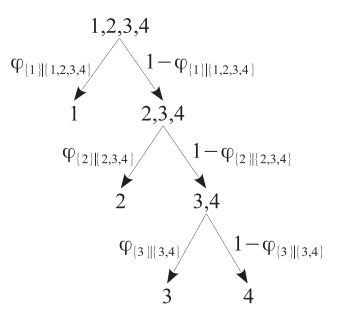

In [34]:
Image('images/fig22_2L.png')

In [36]:
# Number of categories
n_cat = df2.Y.cat.categories.size
# Number of dimensions for X
zX_dim =zX.shape[1]

with pm.Model() as model_cond_log:
    # priors
    zbeta0 = pm.Normal('zbeta0', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta = pm.Normal('zbeta', mu=0, tau=1/20**2, shape=(zX_dim, n_cat-1))
    
    phi = pm.invlogit(zbeta0 + pm.math.dot(zX, zbeta))
  
    mu0 = phi[:,0]
    mu1 = phi[:,1] * (1-phi[:,0])
    mu2 = phi[:,2] * (1-phi[:,1]) * (1-phi[:,0])
    mu3 = (1-phi[:,2]) * (1-phi[:,1]) * (1-phi[:,0])
    mu = pm.math.stack([mu0, mu1, mu2, mu3], axis=1)
    
    y = pm.Categorical('y', p=mu, observed=df2.Y.cat.codes.as_matrix())

In [37]:
with model_cond_log:
    trace2 = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 260.45: 100%|██████████| 200000/200000 [01:11<00:00, 2778.40it/s]
Finished [100%]: Average Loss = 260.46
100%|██████████| 50500/50500 [05:37<00:00, 149.47it/s]


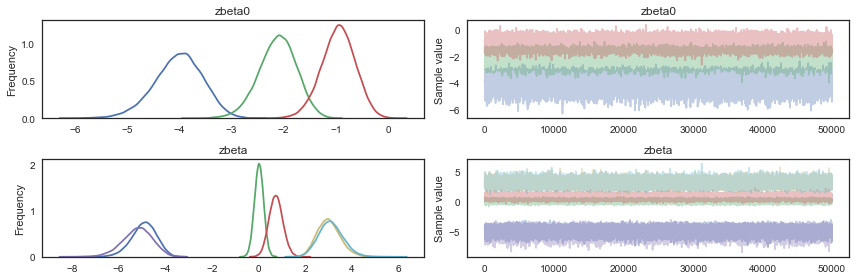

In [38]:
pm.traceplot(trace2);

In [39]:
# Transform parameters back to original scale
zbeta0 = trace2['zbeta0']
zbeta = trace2['zbeta']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat-1,1))/np.tile(scalex, (n_cat-1,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat-1,1)).T)

print(beta0.shape)
print(beta.shape)

(50000, 3)
(50000, 2, 3)


In [40]:
# Join the two multi-dimensional arrays
estimates2 = np.insert(beta, 0, beta0, axis=1)
estimates2.shape

(50000, 3, 3)

#### Figure 22.6

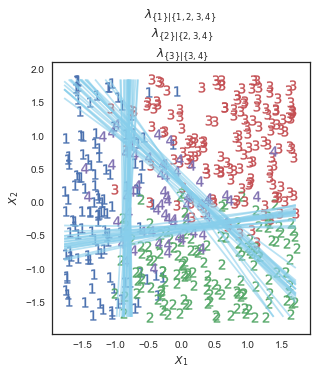

In [41]:
plt.figure(figsize=(5,5))
for outcome in df2.Y.cat.categories:
    plt.scatter(df2[df2.Y == outcome].X1, df2[df2.Y == outcome].X2, s=100, marker='${}$'.format(outcome))

# Take 20 values from the posterior distribution and plot the lines
tr_len = len(trace2)
n_curves = 20
stepIdxVec = np.arange(500, tr_len, tr_len//n_curves)
X1_span = np.linspace(df2.X1.min(), df2.X1.max())
X2_span = np.linspace(df2.X2.min(), df2.X2.max())

# Prepare grid for contour plot
xx, yy = np.meshgrid(X1_span, X2_span, indexing='xy')
Z0 = np.zeros((X2_span.size,X1_span.size))
Z1 = Z0.copy()
Z2 = Z0.copy()
# Calculate p based on grid of X1 and X2
for idx in stepIdxVec:
    for (i,j) in np.ndindex(Z0.shape):
        Z0[i,j] = expit(estimates2[idx,0,0] + np.dot(estimates2[idx,1,0],xx[i,j]) + estimates2[idx,2,0]*yy[i,j])
        Z1[i,j] = expit(estimates2[idx,0,1] + np.dot(estimates2[idx,1,1],xx[i,j]) + estimates2[idx,2,1]*yy[i,j])
        Z2[i,j] = expit(estimates2[idx,0,2] + np.dot(estimates2[idx,1,2],xx[i,j]) + estimates2[idx,2,2]*yy[i,j])
    plt.contour(xx, yy, Z0, colors=color, alpha=0.6, levels=[0.5])
    plt.contour(xx, yy, Z1, colors=color, alpha=0.6, levels=[0.5])
    plt.contour(xx, yy, Z2, colors=color, alpha=0.6, levels=[0.5])
    
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_{\{1\}|\{1,2,3,4\}}$ \n $\lambda_{\{2\}|\{2,3,4\}}$ \n $\lambda_{\{3\}|\{3,4\}}$')
plt.gca().set_aspect('equal')

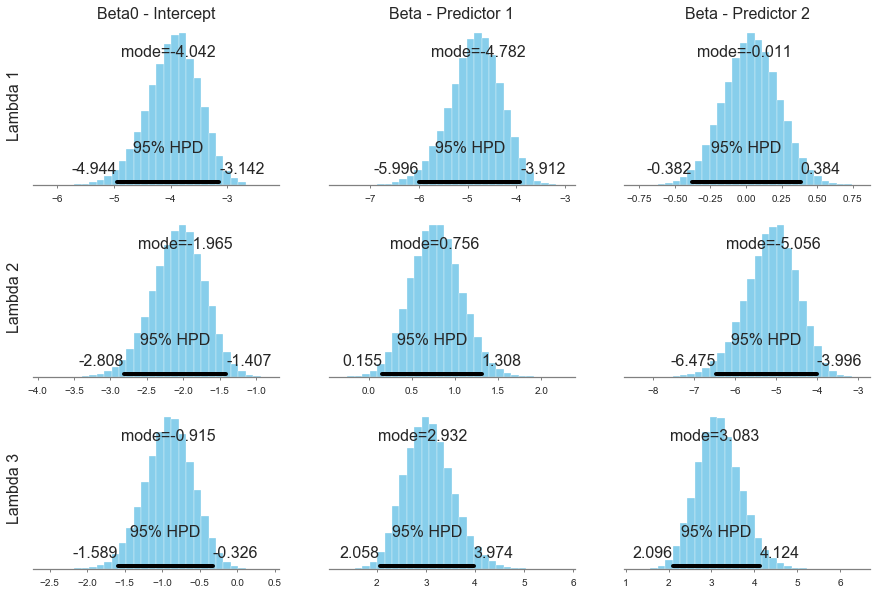

In [42]:
fig, axes = plt.subplots(3,3, figsize=(15,10));
# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    pm.plot_posterior(estimates2[:,c,r], point_estimate='mode', color=color, ax=ax)
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Lambda {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);

#### Model (Kruschke, 2015)

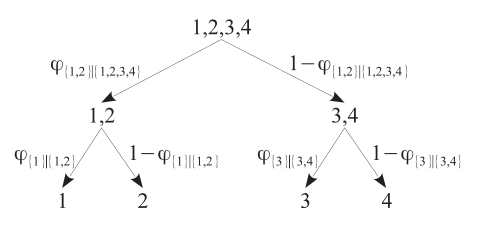

In [43]:
Image('images/fig22_2R.png')

In [44]:
df3 = pd.read_csv('data/CondLogistRegData2.csv', dtype={'Y':'category'})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
X1    475 non-null float64
X2    475 non-null float64
Y     475 non-null category
dtypes: category(1), float64(2)
memory usage: 8.2 KB


In [47]:
# Standardize the data
X = df3[['X1', 'X2']]
meanx = X.mean().values
scalex = X.std().values
zX = ((X-meanx)/scalex).values

# Number of categories
n_cat = df3.Y.cat.categories.size
# Number of dimensions for X
zX_dim =zX.shape[1]

with pm.Model() as model_cond_log2:
    # priors
    zbeta0 = pm.Normal('zbeta0', mu=0, tau=1/20**2, shape=n_cat-1)
    zbeta = pm.Normal('zbeta', mu=0, tau=1/20**2, shape=(zX_dim, n_cat-1))
    
    phi = pm.invlogit(zbeta0 + pm.math.dot(zX, zbeta))
  
    mu0 = phi[:,1] * phi[:,0]
    mu1 = (1-phi[:,1]) * phi[:,0] 
    mu2 = phi[:,2] * (1-phi[:,0])
    mu3 = (1-phi[:,2]) * (1-phi[:,0])
    mu = pm.math.stack([mu0, mu1, mu2, mu3], axis=1)
    
    y = pm.Categorical('y', p=mu, observed=df3.Y.cat.codes.as_matrix())

In [48]:
with model_cond_log2:
    trace3 = pm.sample(50000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 248.49: 100%|██████████| 200000/200000 [01:06<00:00, 3018.88it/s]
Finished [100%]: Average Loss = 248.5
100%|██████████| 50500/50500 [07:13<00:00, 116.54it/s]


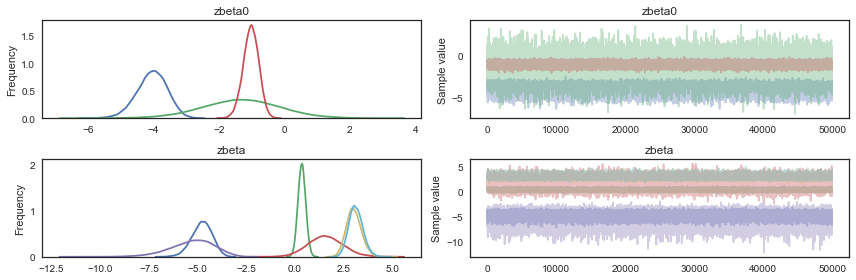

In [49]:
pm.traceplot(trace3);

In [50]:
# Transform parameters back to original scale
zbeta0 = trace3['zbeta0']
zbeta = trace3['zbeta']

beta0 = zbeta0 - np.sum(zbeta*(np.tile(meanx, (n_cat-1,1))/np.tile(scalex, (n_cat-1,1))).T, axis=1)
beta = np.divide(zbeta, np.tile(scalex, (n_cat-1,1)).T)

print(beta0.shape)
print(beta.shape)

(50000, 3)
(50000, 2, 3)


In [51]:
# Join the two multi-dimensional arrays
estimates3 = np.insert(beta, 0, beta0, axis=1)
estimates3.shape

(50000, 3, 3)

#### Figure 22.7

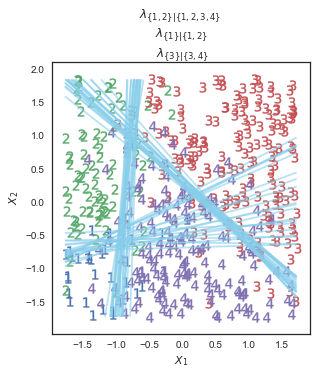

In [52]:
plt.figure(figsize=(5,5))
for outcome in df3.Y.cat.categories:
    plt.scatter(df3[df3.Y == outcome].X1, df3[df3.Y == outcome].X2, s=100, marker='${}$'.format(outcome))
    
# Take 20 values from the posterior distribution and plot the lines
tr_len = len(trace2)
n_curves = 20
stepIdxVec = np.arange(500, tr_len, tr_len//n_curves)
X1_span = np.linspace(df3.X1.min(), df3.X1.max())
X2_span = np.linspace(df3.X2.min(), df3.X2.max())

# Prepare grid for contour plot
xx, yy = np.meshgrid(X1_span, X2_span, indexing='ij')
Z0 = np.zeros((X2_span.size,X1_span.size))
Z1 = Z0.copy()
Z2 = Z0.copy()
# Calculate p based on grid of X1 and X2
for idx in stepIdxVec:
    for (i,j) in np.ndindex(Z0.shape):
        Z0[i,j] = expit(estimates3[idx,0,0] + np.dot(estimates3[idx,1,0],xx[i,j]) + estimates3[idx,2,0]*yy[i,j])
        Z1[i,j] = expit(estimates3[idx,0,1] + np.dot(estimates3[idx,1,1],xx[i,j]) + estimates3[idx,2,1]*yy[i,j])
        Z2[i,j] = expit(estimates3[idx,0,2] + np.dot(estimates3[idx,1,2],xx[i,j]) + estimates3[idx,2,2]*yy[i,j])
    plt.contour(xx, yy, Z0, colors=color, alpha=0.6, levels=[0.5])
    plt.contour(xx, yy, Z1, colors=color, alpha=0.6, levels=[0.5])
    plt.contour(xx, yy, Z2, colors=color, alpha=0.6, levels=[0.5])    
        
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('$\lambda_{\{1,2\}|\{1,2,3,4\}}$ \n $\lambda_{\{1\}|\{1,2\}}$ \n $\lambda_{\{3\}|\{3,4\}}$')
plt.gca().set_aspect('equal')

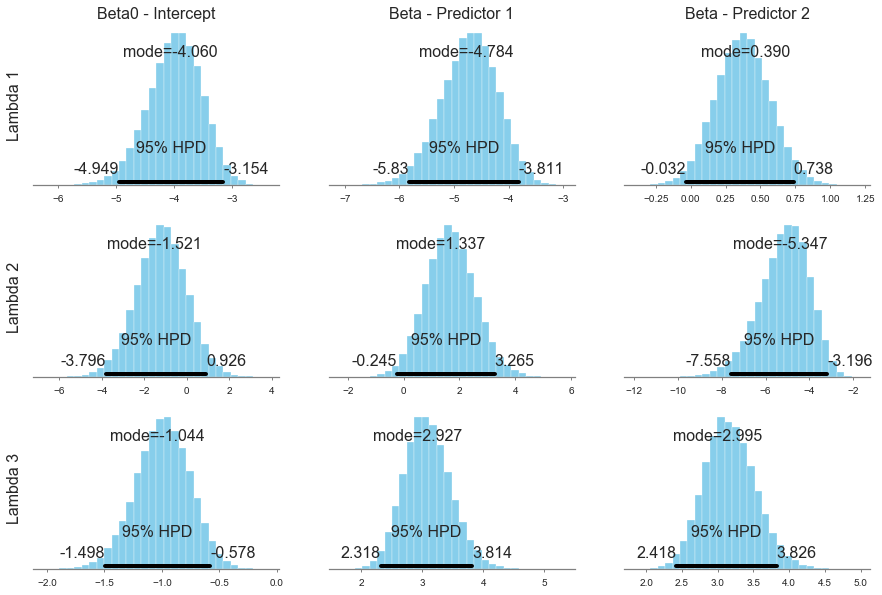

In [53]:
fig, axes = plt.subplots(3,3, figsize=(15,10));
# Plot the posterior distributions
for (r,c), ax in np.ndenumerate(axes):
    pm.plot_posterior(estimates3[:,c,r], point_estimate='mode', color=color, ax=ax)
    
# Setting labels for the outcomes
for r, ax in enumerate(axes[:,0]):
    ax.set_ylabel('Lambda {}'.format(r+1), fontdict=f_dict)

# Setting labels for the predictors
for ax, title in zip(axes[0,:], ['Beta0 - Intercept', 'Beta - Predictor 1', 'Beta - Predictor 2']):
    ax.set_title(title, fontdict=f_dict);